# Image Stacking Exercise
#### Written by Gautham Narayan (gnarayan@stsci.edu) for LSST DSFP #5

### In the last couple of exercises, you determined the WCS solution for a couple of images and reprojected them on to a common grid. That process is slow, so for this exercise I'm just going to give you a lot of reprojected images to begin with. While it's not "Big Data" it's bigger than GitHub will manage, so I've stored it on Dropbox. Get this and extract it. 

## https://www.dropbox.com/s/7cpuegjdxv6lte7/bundle_sw.tar.gz?dl=0

### Eventually Adam and I will coordinate and this will be on Box and we can edit these notebooks, or add another README file or something, but the Dropbox link isn't going anyway for the forseeable future.

### These images were reprojected using the SWarp code, and when we did this we also produced a (gzipped) noise (sigma) map and a weight (mask) map.

In [1]:
!ls ../wdd7_6/warped/ | head -n 10

wdd7.040920_0452.051_6.sw.fits
wdd7.040920_0452.051_6.sw.noise.fits.gz
wdd7.040920_0452.051_6.sw.weight.fits.gz
wdd7.041009_0300.1070_6.sw.fits
wdd7.041009_0300.1070_6.sw.noise.fits.gz
wdd7.041009_0300.1070_6.sw.weight.fits.gz
wdd7.041013_0301.058_6.sw.fits
wdd7.041013_0301.058_6.sw.noise.fits.gz
wdd7.041013_0301.058_6.sw.weight.fits.gz
wdd7.041017_0303.1050_6.sw.fits


### We used both of these extra images to generate a weight per image for image stacking or when doing image subtraction. Depending on how you proceed with this exercise, you could use one or both, or ignore them altogether. 

### Begin by taking a look at a single image's FITS header

In [2]:
!imhead ../wdd7_6/warped/wdd7.040920_0452.051_6.sw.fits

SIMPLE  =                    T / This is a FITS file
BITPIX  =                   16 /
NAXIS   =                    2 /
NAXIS1  =                 4160 / NUMBER OF ELEMENTS ALONG THIS AXIS
NAXIS2  =                 1100 / NUMBER OF ELEMENTS ALONG THIS AXIS
EXTEND  =                    T / This file may contain FITS extensions
BSCALE  =             1.000000 /
BZERO   =         32768.000000 /
EQUINOX =            2000.0000 / Mean equinox
RADECSYS= 'FK5     '           / Astrometric system
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis
CUNIT1  = 'deg     '           / Axis unit
CRVAL1  =      3.820150417E+01 / World coordinate on this axis
CRPIX1  =      2.080500000E+03 / Reference pixel on this axis
CD1_1   =     -7.500000298E-05 / Linear projection matrix
CD1_2   =      0.000000000E+00 / Linear projection matrix
CTYPE2  = 'DEC--TAN'           / WCS projection type for this axis
CUNIT2  = 'deg     '           / Axis unit
CRVAL2  =     -8.816311111E+00 / World coordinate

### You might also want to look at the data (it's ALWAYS a good idea to check) with ds9 and get a sense for it. Are they really aligned or do I just have no idea what I did back when I was a wee grad student (it's ALWAYS a good idea to check...). 

### For example, did I actually take out the background? Are the PSFs similar-ish? Are the exposure times the same. WCSTools gethead is your friend.

In [3]:
%matplotlib notebook
%pylab
import astropy.io.fits as afits
### astropy can seamlessly handle the gzipped fits images

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


### Then, write a function that takes a filename and loads data from the image and the header that you think might be useful to weight the images by when producing a stack. (hint: SKYADU might be useful, maybe AIRMASS, ZPTMAG, EXPTIME - I'm tossing out suggestions - you can pick and examine what happens with different choices).

In [4]:
# you could use the masks and weights, but they were generated for SWarp, and it should come as no surprise that
# it's easier and faster to use them with SWarp. It's a pretty big stack (I wanted you to see clear improvement)
# So we will just use the image data itself. I'm even tossing the WCS for this exercise. 
def load_image(filename):
    f = afits.open(filename)
    data = f[0].data.astype('float64')
    skyadu = float(f[0].header.get('SKYADU'))
    zptmag = float(f[0].header.get('ZPTMAG'))
    data -= skyadu
    return (data, zptmag)

### Load the data into whatever structure you like - numpy (masked array), list, dictionary - whatever you are comfortable with slicing and dicing.

In [5]:
import glob
load_image('../wdd7_6/warped/wdd7.040920_0452.051_6.sw.fits')
files = glob.glob('../wdd7_6/warped/wdd7*6.sw.fits')
images = [load_image(f) for f in files]
images, zptmag = zip(*images)
images = np.array(images)
zptmag = np.array(zptmag)

### Now that the data is loaded, decide on how you'd like to weight the data. Normalize them in some sensible way. You'll be comparing this against a median stack and an unweighted simple average.

In [6]:
weights = 10.**-0.4*zptmag # I'm just using the flux zeropoint to set the weights
wsum = np.sum(weights)
weights /= wsum

### Create the stacks - median, unweighted mean and using your weighting function

### If you decided to use the masks, make sure you use the corresponding functions in numpy.ma

### if you want to get fancy, you can even try astropy.stats.sigma_clip, and then you'll have tried the most commonly used stacking methods with SWarp

In [7]:
# yeah this is slow
from astropy.stats import sigma_clip
unweighted_stack = np.mean(images, axis=0)
median_stack = np.median(images, axis=0)
weighted_stack = np.average(images, weights=weights, axis=0)
sigma_clipped_stack = np.ma.average(sigma_clip(images, axis=0, sigma=3, iters=5), weights=weights, axis=0)

In [8]:
from astropy.visualization import ZScaleInterval
zscaler = ZScaleInterval(nsamples=1000, contrast=0.25)

### Plot up the stacks you made + one of the original images for comparison. I've saved my example output in the out directory

<IPython.core.display.Javascript object>


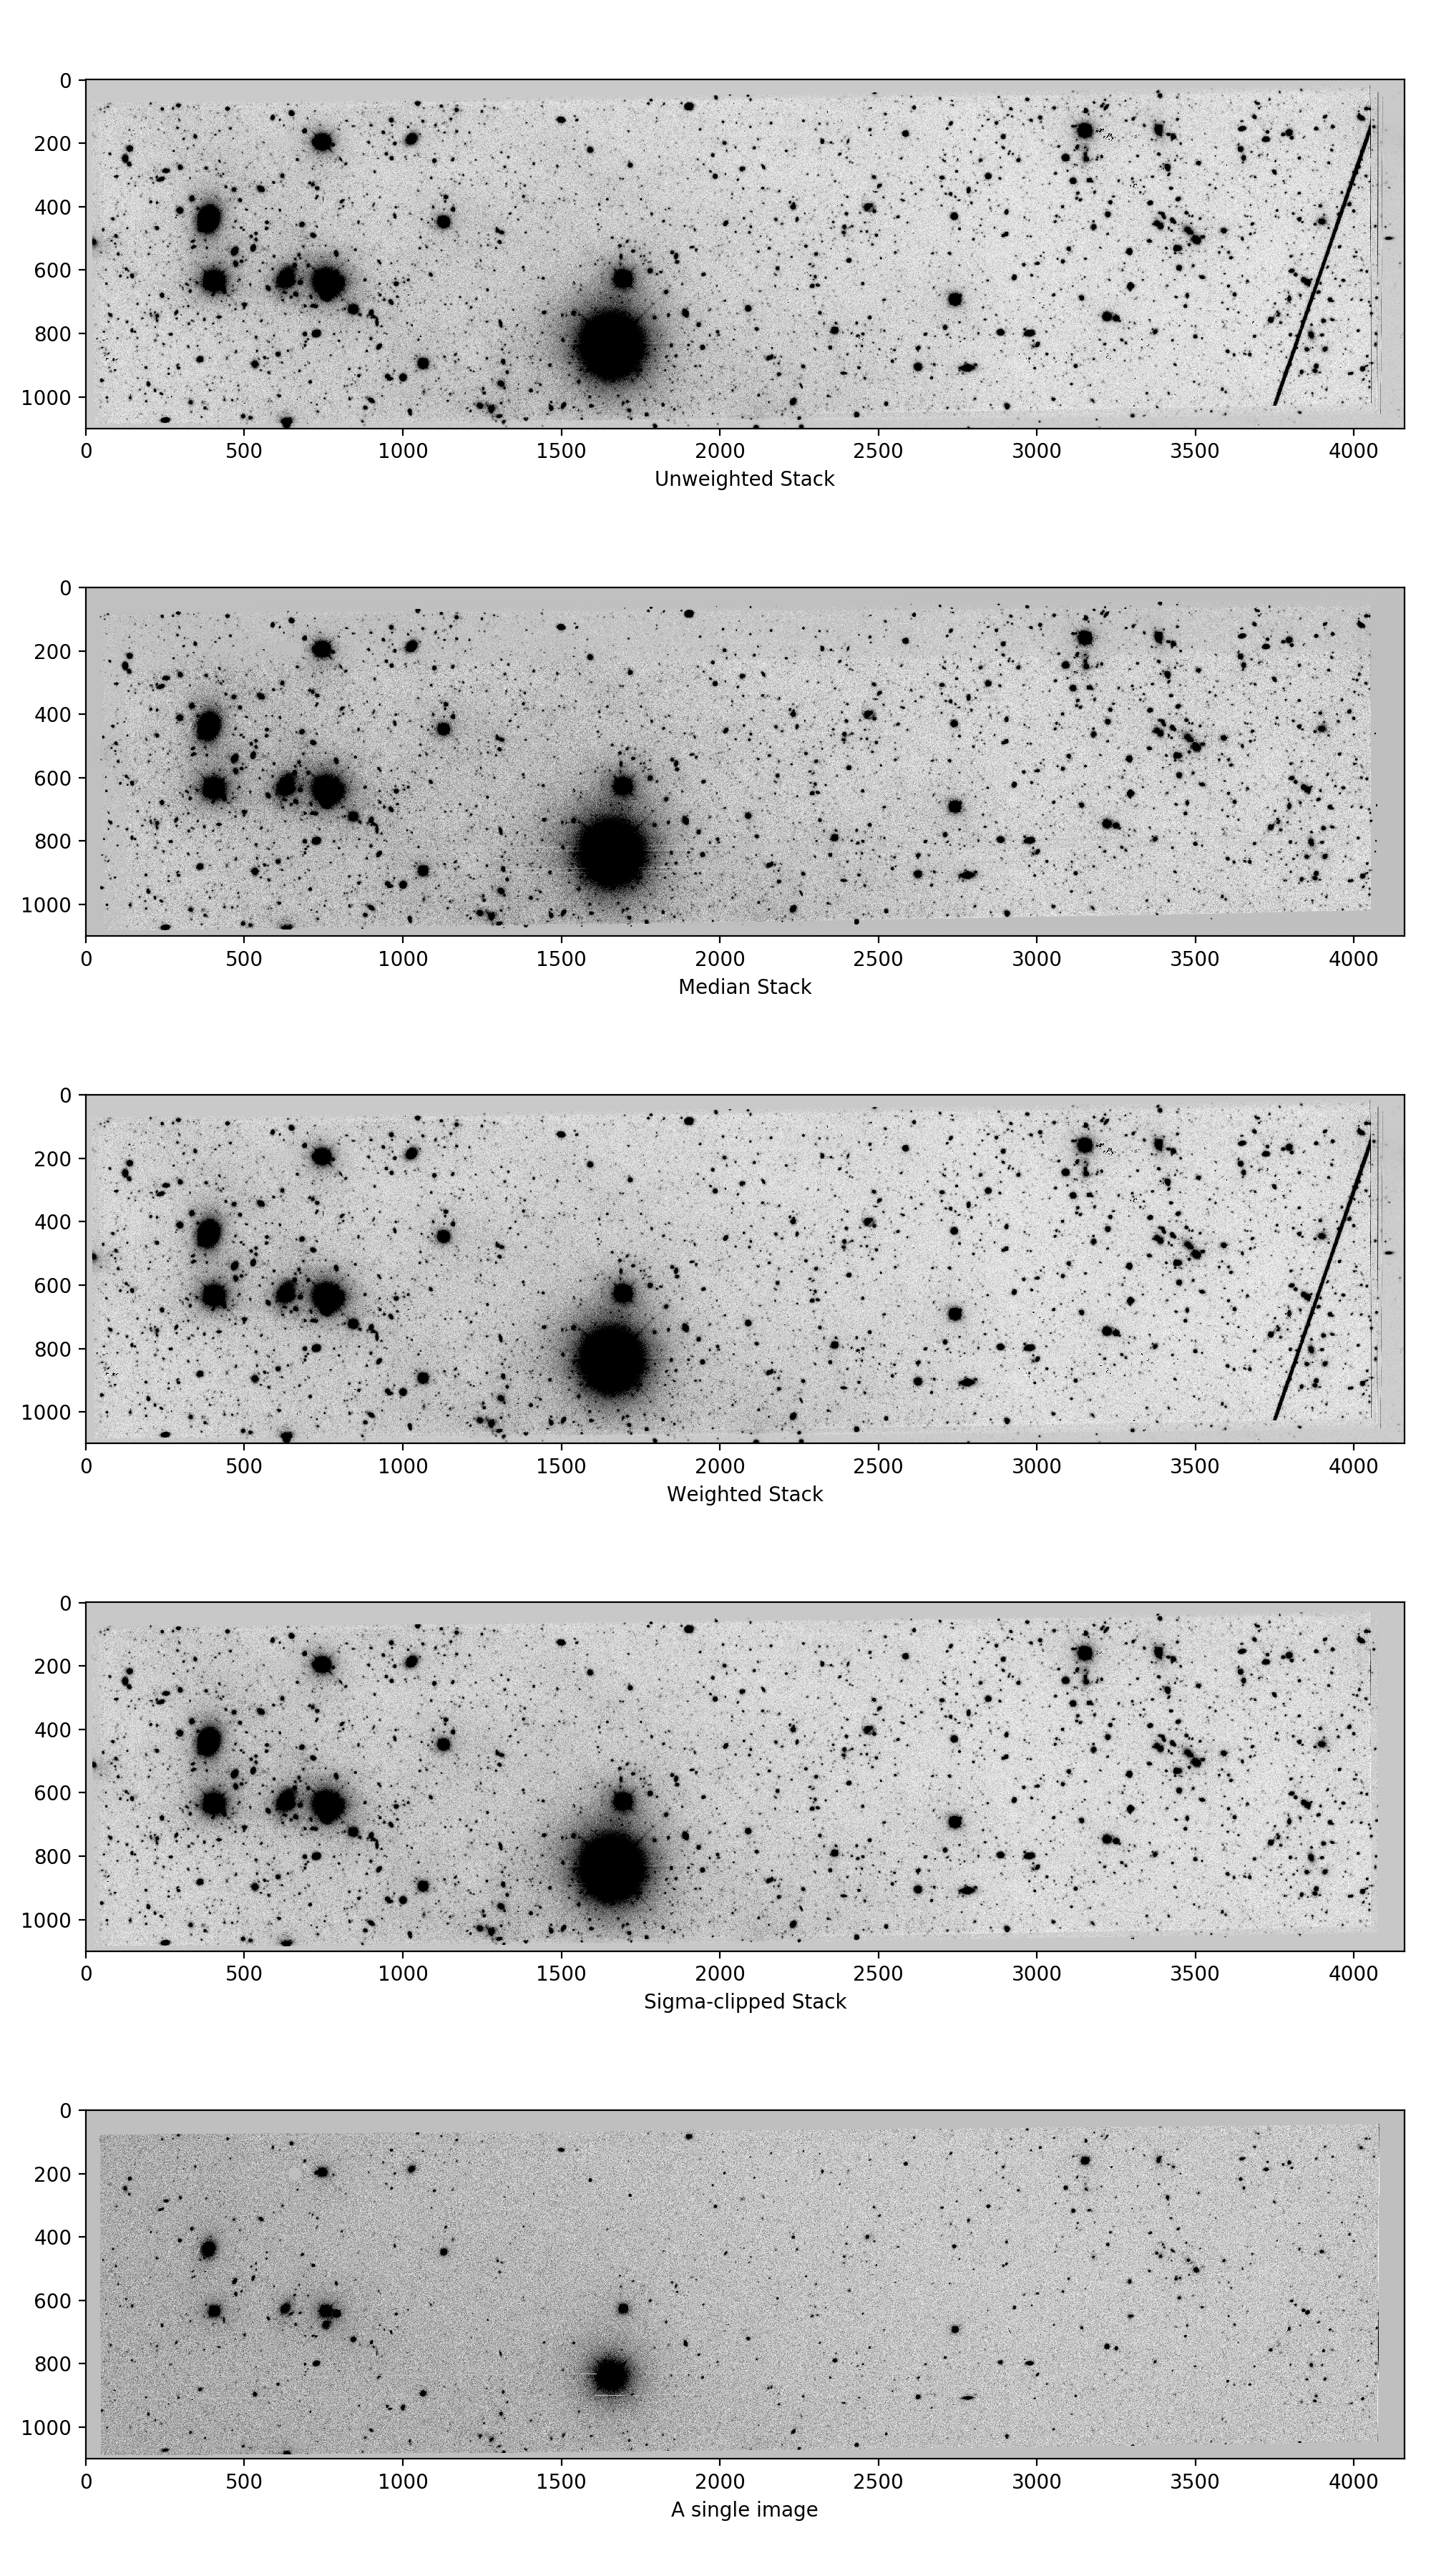

In [9]:
fig = figure(figsize=(10,18))

ax1 = fig.add_subplot(5,1,1)
ax2 = fig.add_subplot(5,1,2)
ax3 = fig.add_subplot(5,1,3)
ax4 = fig.add_subplot(5,1,4)
ax5 = fig.add_subplot(5,1,5)
ax1.imshow(zscaler(unweighted_stack), cmap='Greys')
ax2.imshow(zscaler(median_stack), cmap='Greys')
ax3.imshow(zscaler(weighted_stack), cmap='Greys')
ax4.imshow(zscaler(sigma_clipped_stack), cmap='Greys')
ax5.imshow(zscaler(images[0,:,:]), cmap='Greys')

ax1.set_xlabel('Unweighted Stack')
ax2.set_xlabel('Median Stack')
ax3.set_xlabel('Weighted Stack')
ax4.set_xlabel('Sigma-clipped Stack')
ax5.set_xlabel('A single image')

tight_layout()
savefig('out/stacks.pdf')